In [1]:
import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd
import cv2

In [2]:
lscc_root = 'D:\\CPTAC_LAUD'

In [3]:
ct_root = os.path.join(lscc_root, 'image')

In [4]:
np_root = os.path.join(lscc_root, 'numpy')

In [5]:
resampled_root = os.path.join(lscc_root, 'resampled')

In [6]:
png_root = os.path.join(lscc_root, 'png')

In [7]:
ct_data = os.listdir(ct_root)

In [8]:
patient_number = []
for i in ct_data:
    if 'roi' not in i:
        C, nii, gz = i.split('.')
        c, num = C.split('-')
        patient_number.append(str(int(num)))

In [9]:
# for number in patient_number:
#     resampled_path = os.path.join(resampled_root, number)
#     numpy_path = os.path.join(np_root, number)
#     os.mkdir(resampled_path)
#     os.mkdir(numpy_path)

In [10]:
patient_number

['199',
 '293',
 '704',
 '738',
 '959',
 '1799',
 '2281',
 '2672',
 '2721',
 '2950',
 '2973',
 '3222',
 '3233',
 '3420',
 '3764',
 '3911',
 '4173']

## CT resampling

In [11]:
for data in ct_data:
    if 'roi' not in data:
        C, nii, gz = data.split('.')
        c, num = C.split('-')
        num = str(int(num))
        
        img_root = os.path.join(ct_root, data)
        img = sitk.ReadImage(img_root)
        img_np = sitk.GetArrayFromImage(img)
        img_min = int(img_np.min())
        size = img.GetSize()

        reference_np = np.zeros((size[2], size[1], size[0]))
        reference_img = sitk.GetImageFromArray(reference_np)
        reference_img.CopyInformation(img)
        reference_img.SetSpacing([1.0, 1.0, 1.0])

        resampler = sitk.ResampleImageFilter()
        resampler.SetReferenceImage(reference_img)
        resampler.SetInterpolator(sitk.sitkBSplineResamplerOrder3)
        resampler.SetDefaultPixelValue(img_min)

        orig_size = np.array(img.GetSize(), dtype=np.int)
        orig_spacing = img.GetSpacing()
        new_size = orig_size*(orig_spacing)
        new_size = np.ceil(new_size).astype(np.int)
        new_size = [int(s) for s in new_size]
        resampler.SetSize(new_size)

        new_img = resampler.Execute(img)

        resample_path = os.path.join(resampled_root + '\\' + num, data)
        sitk.WriteImage(new_img, resample_path)

## ROI image resampling

In [12]:
for data in ct_data:
    if 'roi' in data:
        C, roi, nii, gz = data.split('.')
        c, num = C.split('-')
        num = str(int(num))
        
        roi_root = os.path.join(ct_root, data)
        roi = sitk.ReadImage(roi_root) 
        roi_np = sitk.GetArrayFromImage(roi)
        roi_min = int(roi_np.min())
        size = roi.GetSize()

        reference_np = np.zeros((size[2], size[1], size[0]))
        reference_img = sitk.GetImageFromArray(reference_np)
        reference_img.CopyInformation(roi)
        reference_img.SetSpacing([1.0, 1.0, 1.0])

        resampler = sitk.ResampleImageFilter()
        resampler.SetReferenceImage(reference_img)
        resampler.SetInterpolator(sitk.sitkNearestNeighbor)
        resampler.SetDefaultPixelValue(roi_min)

        orig_size = np.array(roi.GetSize(), dtype=np.int)
        orig_spacing = roi.GetSpacing()
        new_size = orig_size*(orig_spacing)
        new_size = np.ceil(new_size).astype(np.int)
        new_size = [int(s) for s in new_size]
        resampler.SetSize(new_size)

        new_roi = resampler.Execute(roi)

        resample_roi_path = os.path.join(resampled_root + '\\' + num, data)
        sitk.WriteImage(new_roi, resample_roi_path)

## Resampled image slice check

In [13]:
thick = {}
z_thick = {}
for data in ct_data:
    if 'roi' in data :
        C, roi, nii, gz = data.split('.')
        c, num = C.split('-')
        num = str(int(num))
        
        roi_origin_root = os.path.join(ct_root, data)
        roi_origin = sitk.ReadImage(roi_origin_root)
        spacing = roi_origin.GetSpacing()
        thick[num] = spacing
        z_thick[num] = roi_origin.GetSpacing()[2]

In [14]:
thickness = [value for key, value in z_thick.items()]

In [15]:
thickness_set = set(thickness)

In [16]:
thick_count = {}
for i in thickness_set:
    thick_count[i] = 0
    for j in thickness : 
        if i == j :
            thick_count[i] += 1

In [17]:
thick_count

{0.5: 2, 1.25: 3, 2.5: 2, 3.0: 5, 0.70001220703125: 1, 1.0: 2, 1.5: 1, 3.75: 1}

## ROI max slice

In [18]:
per_patient_max_slice = np.array([])
per_patient_max_slice_dict = {}
per_patient_total_max_slice_dict = {}
patient_no = os.listdir(resampled_root)
for no in patient_no:
    patient_root = os.path.join(resampled_root, no)
    patient_data = os.listdir(patient_root)
    for data in patient_data:
        if 'roi' in data:
            roi_root = os.path.join(patient_root, data)
            roi = sitk.ReadImage(roi_root) 
            roi_np = sitk.GetArrayFromImage(roi)
            roi_min = int(roi_np.min())
            
            per_slice_roi_pixel_count = np.array([])
            for i in range(len(roi_np)):
                roi_z = roi_np[i]
                roi_count = len(np.where(roi_z != roi_min)[0])
                per_slice_roi_pixel_count = np.append(per_slice_roi_pixel_count, roi_count)
                
            max_slice = np.max(per_slice_roi_pixel_count)
            z_slice_no = np.where(per_slice_roi_pixel_count == max_slice)[0]
            per_patient_max_slice = np.append(per_patient_max_slice, z_slice_no)
            per_patient_total_max_slice_dict[str(no)] = z_slice_no
            per_patient_max_slice_dict[str(no)] = z_slice_no[0]

In [19]:
max_slice = pd.DataFrame(per_patient_max_slice_dict, index = [0])

In [20]:
max_slice

,1799,199,2281,2672,2721,293,2950,2973,3222,3233,3420,3764,3911,4173,704,738,959
0,26,176,187,117,205,239,38,179,579,483,31,237,114,775,205,205,596


## ROI column and raw check

In [21]:
row_col_check_dict = {}
row_col_check_np = np.array([])
row_col_check_np = row_col_check_np.reshape(0, 4)
patient_no = os.listdir(resampled_root)
for no in patient_no:
    patient_root = os.path.join(resampled_root, no)
    patient_data = os.listdir(patient_root)
    col_check = np.array([])
    row_check = np.array([])

    for data in patient_data:
        if 'roi' in data:
            roi_root = os.path.join(patient_root, data)
            roi_img = sitk.ReadImage(roi_root)
            roi_np = sitk.GetArrayFromImage(roi_img)
            roi_min = int(roi_np.min())
            
            max_slice_no = per_patient_max_slice_dict[str(no)]
            max_slice = roi_np[max_slice_no]
            for i in range(max_slice.shape[0]):
                roi_count = np.where(max_slice[i] != roi_min)[0]
                col_check = np.append(col_check, roi_count)
            col_check_unique = np.unique(col_check)
                
            for j in range(max_slice.shape[1]):
                roi_count = np.where(max_slice[:, j] != roi_min)[0]
                row_check = np.append(row_check, roi_count)
            row_check_unique = np.unique(row_check)      

            row_min = int(row_check_unique.min())
            row_max = int(row_check_unique.max())
            col_min = int(col_check_unique.min())
            col_max = int(col_check_unique.max())
            
            idx = [row_min, row_max, col_min, col_max]
            idx_np = np.array(idx)
            idx_np = idx_np.reshape(1, 4)
            
    row_col_check_dict[no] = idx
    row_col_check_np = np.append(row_col_check_np, idx_np, axis = 0)

In [23]:
roi_column_row = pd.DataFrame(row_col_check_dict, index = ['row_min', 'row_max', 'col_min', 'col_max'])

In [24]:
roi_column_row.to_csv(lscc_root + '\\roi_column_row.csv')

In [26]:
roi_size_per_patient_dict = {}
roi_size_dict = {}
roi_size_per_patient_np = np.array([])
roi_size_per_patient_np = roi_size_per_patient_np.reshape(0, 2)
roi_center_per_patient_dict = {}
roi_center_per_patient_np = np.array([])
roi_center_per_patient_np = roi_center_per_patient_np.reshape(0, 2)

for key in row_col_check_dict:
    length = row_col_check_dict[key][1] - row_col_check_dict[key][0]
    mid_length = int((row_col_check_dict[key][1] + row_col_check_dict[key][0]) / 2) 
    width = row_col_check_dict[key][3] - row_col_check_dict[key][2]
    mid_width = int((row_col_check_dict[key][3] + row_col_check_dict[key][2]) / 2)
    size = [length, width]
    center = [mid_length, mid_width]
    size_np = np.array(size)
    size_np = size_np.reshape(1, 2)
    center_np = np.array(center)
    center_np = center_np.reshape(1, 2)
    roi_size_per_patient_dict[key] = size
    roi_size_dict[key] = max(size)
    roi_size_per_patient_np = np.append(roi_size_per_patient_np, size_np, axis = 0)
    roi_center_per_patient_dict[key] = center
    roi_center_per_patient_np = np.append(roi_center_per_patient_np, center_np, axis = 0)

In [27]:
roi_center_per_patient_dict

{'1799': [127, 273],
 '199': [173, 245],
 '2281': [297, 173],
 '2672': [212, 99],
 '2721': [248, 263],
 '293': [239, 112],
 '2950': [125, 104],
 '2973': [281, 86],
 '3222': [324, 310],
 '3233': [237, 154],
 '3420': [240, 86],
 '3764': [190, 100],
 '3911': [185, 88],
 '4173': [276, 308],
 '704': [120, 72],
 '738': [158, 66],
 '959': [395, 488]}

In [28]:
roi_center = pd.DataFrame(roi_center_per_patient_dict, index = ['mid_length', 'mid_width'])

In [29]:
roi_center.to_csv(lscc_root + '\\roi_center.csv')

In [30]:
roi_max_size = max([value for (key, value) in roi_size_dict.items()])

In [31]:
roi_max_size

88

In [32]:
cut_size = 64

## Crop CT and ROI image(roi size&3channel)

In [33]:
no = os.listdir(resampled_root)
for no in patient_no :
    patient_root = os.path.join(resampled_root, no)
    patient_data = os.listdir(patient_root)
    patient_np_root = os.path.join(np_root, no)

    for data in patient_data:
        if 'roi' in data:
            roi_root = os.path.join(patient_root, data)
            roi_img = sitk.ReadImage(roi_root)
            roi_np = sitk.GetArrayFromImage(roi_img)
            roi_min = roi_np.min()
            
            roi_background = np.full((3, 128, 128), roi_min)
            max_slice_no = per_patient_max_slice_dict[str(no)]

            max_slice_roi_pre = roi_np[max_slice_no - 3]
            max_slice_roi_mid = roi_np[max_slice_no]
            max_slice_roi_post = roi_np[max_slice_no + 3]

            roi_row_center = roi_center_per_patient_dict[no][0]
            roi_col_center = roi_center_per_patient_dict[no][1]

            row_start_point = roi_row_center - cut_size
            row_end_point = roi_row_center + cut_size 
            col_start_point = roi_col_center - cut_size
            col_end_point = roi_col_center + cut_size

            roi_cut_pre = max_slice_roi_pre[row_start_point:row_end_point, col_start_point:col_end_point]
            roi_cut_mid = max_slice_roi_mid[row_start_point:row_end_point, col_start_point:col_end_point]
            roi_cut_post = max_slice_roi_post[row_start_point:row_end_point, col_start_point:col_end_point]

            if max_slice_roi_mid.min() == -1024:
                roi_cut_pre = roi_cut_pre + 1024
                roi_cut_mid = roi_cut_mid + 1024
                roi_cut_post = roi_cut_post + 1024

            for i in range(roi_cut_pre.shape[0]):
                for j in range(roi_cut_pre.shape[1]):
                    roi_background[0][i][j] = roi_cut_pre[i][j]
                    roi_background[1][i][j] = roi_cut_mid[i][j]
                    roi_background[2][i][j] = roi_cut_post[i][j]

            np.save(patient_np_root + '\\roi', roi_background)

        else:
            ct_root = os.path.join(patient_root, data)
            ct_img = sitk.ReadImage(ct_root)
            ct_np = sitk.GetArrayFromImage(ct_img)
            ct_min = ct_np.min()
            
            ct_background = np.full((3, 128, 128), ct_min)
            max_slice_no = per_patient_max_slice_dict[str(no)]

            max_slice_ct_pre = ct_np[max_slice_no - 3]        
            max_slice_ct_mid = ct_np[max_slice_no]
            max_slice_ct_post = ct_np[max_slice_no + 3]

            roi_row_center = roi_center_per_patient_dict[no][0]
            roi_col_center = roi_center_per_patient_dict[no][1]

            row_start_point = roi_row_center - cut_size
            row_end_point = roi_row_center + cut_size 
            col_start_point = roi_col_center - cut_size
            col_end_point = roi_col_center + cut_size
            if row_start_point < 0:
                row_start_point = 0
            if row_end_point < 0 :
                row_end_point = 0
            if col_start_point < 0:
                col_start_point = 0
            if col_end_point < 0:
                col_end_point = 0
            
            ct_cut_pre = max_slice_ct_pre[row_start_point:row_end_point, col_start_point:col_end_point]
            ct_cut_mid = max_slice_ct_mid[row_start_point:row_end_point, col_start_point:col_end_point]
            ct_cut_post = max_slice_ct_post[row_start_point:row_end_point, col_start_point:col_end_point]

            for i in range(ct_cut_pre.shape[0]) :
                for j in range(ct_cut_pre.shape[1]):
                    ct_background[0][i][j] = ct_cut_pre[i][j]
                    ct_background[1][i][j] = ct_cut_mid[i][j]
                    ct_background[2][i][j] = ct_cut_post[i][j]

            np.save(patient_np_root + '\\ct', ct_background)

## min intensity check

In [34]:
no = os.listdir(np_root)

In [35]:
min_check = {}
max_check = {}
range_check = {}
for num in no:
    num_root = os.path.join(np_root, num)
    data = os.listdir(num_root)
    for nps in data:
        if 'ct' in nps:
            ct_root = os.path.join(num_root, nps)
            ct = np.load(ct_root)
            min_value = ct.min()
            min_check[num] = min_value
            max_value = ct.max()
            max_check[num] = max_value
            range_check[num] = max_value - min_value

In [36]:
max_intensity = pd.DataFrame(max_check, index = ['max']).transpose()
min_intensity = pd.DataFrame(min_check, index = ['min']).transpose()
range_intensity = pd.DataFrame(range_check, index = ['range']).transpose()

In [39]:
patient_intensity = pd.concat([max_intensity, min_intensity, range_intensity], axis = 1)

In [40]:
patient_intensity.to_csv(lscc_root + '\\patient_intensity.csv')

In [41]:
modified_patient = [key for key, values in min_check.items() if int(values) < -1024 ]

In [42]:
modified_patient

[]

## Data normalization

In [8]:
np_number = os.listdir(np_root)

In [44]:
for number in np_number:
    patient_np_root = os.path.join(np_root, number)
    data = os.listdir(patient_np_root)
    for nps in data:
        if nps == 'ct_m.npy':
            ct_np_root = os.path.join(patient_np_root, nps)
            ct_np = np.load(ct_np_root)
            ct_normalization = (ct_np - (-1024)) / (3071 - (-1024))
            np.save(patient_np_root + '\\ct_normalized.npy', ct_normalization)
        elif nps == 'ct.npy':
            ct_np_root = os.path.join(patient_np_root, nps)
            ct_np = np.load(ct_np_root)
            ct_normalization = (ct_np - (-1024)) / (3071 - (-1024))
            np.save(patient_np_root + '\\ct_normalized.npy', ct_normalization)

## Total data

In [9]:
final_root = os.path.join(lscc_root, 'final_data_p')

In [10]:
label_csv = lscc_root + '\\LAUD.xlsx'
label_data = pd.read_excel(label_csv)

In [11]:
non_con = label_data[label_data['image'] == 1]

In [12]:
label = pd.concat([non_con['case_id'], non_con['Contrast'], non_con['tumor_stage_pathological']], axis = 1)

In [13]:
label = label.reset_index(drop = True)

In [14]:
label

,case_id,Contrast,tumor_stage_pathological
0,C3N-00199,non-con,Stage IA
1,C3N-00293,non-con,Stage IB
2,C3N-00704,non-con,Stage IB
3,C3N-00738,non-con,Stage IA
4,C3N-00959,non-con,Stage IB
5,C3N-01799,non-con,Stage IIA
6,C3N-02281,non-con,Stage IIA
7,C3N-02672,con(non-con),Stage III
8,C3N-02721,con(non-con),Stage IB
9,C3N-02950,non-con,Stage 1B


In [18]:
stage_check = {}
for i in range(len(label)):
    ID = label['case_id'][i]
    _, num = ID.split('-')
    num = str(int(num))
    grade = label['tumor_stage_pathological'][i]
    if 'ⅣA' in grade:
        new_grade = 4
    elif 'III' in grade:
        new_grade = 3
    elif 'II' in grade:
        new_grade = 2
    elif 'I' in grade:
        new_grade = 1
    stage_check[num] = int(new_grade)

In [19]:
stage_check

{'199': 1,
 '293': 1,
 '704': 1,
 '738': 1,
 '959': 1,
 '1799': 2,
 '2281': 2,
 '2672': 3,
 '2721': 1,
 '2950': 1,
 '2973': 1,
 '3222': 1,
 '3233': 1,
 '3420': 2,
 '3764': 2,
 '3911': 1,
 '4173': 1}

In [20]:
p_patient = [key for (key, values) in stage_check.items()]

In [21]:
ct_total = np.array([]).reshape(0, 3, 128, 128)
roi_total = np.array([]).reshape(0, 3, 128, 128)
stage_numpy = np.array([])
stage_dict = {}
for i in range(len(p_patient)):
    patient_np_root = os.path.join(np_root, p_patient[i])
    data = os.listdir(patient_np_root)
    for nps in data:
        if nps == 'ct_normalized.npy':
            ct_path = os.path.join(patient_np_root, nps)
            ct_np = np.load(ct_path).reshape(1, 3, 128, 128)
            ct_total = np.append(ct_total, ct_np, axis = 0)
        elif nps == 'roi.npy':
            roi_path = os.path.join(patient_np_root, nps)
            roi_np = np.load(roi_path).reshape(1, 3, 128, 128)
            roi_total = np.append(roi_total, roi_np, axis = 0)
    stage = stage_check[str(int(p_patient[i]))]
    stage_numpy = np.append(stage_numpy, stage)
    stage_dict[str(int(p_patient[i]))] = stage

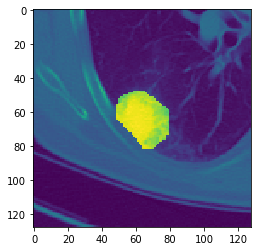

In [22]:
plt.imshow(ct_total[10][1] + (roi_total[10][1]*0.5))

In [23]:
stage_dict

{'199': 1,
 '293': 1,
 '704': 1,
 '738': 1,
 '959': 1,
 '1799': 2,
 '2281': 2,
 '2672': 3,
 '2721': 1,
 '2950': 1,
 '2973': 1,
 '3222': 1,
 '3233': 1,
 '3420': 2,
 '3764': 2,
 '3911': 1,
 '4173': 1}

In [24]:
np.save(final_root + '\\ct_total.npy', ct_total)
np.save(final_root + '\\roi_total.npy', roi_total)
np.save(final_root + '\\stage_total.npy', stage_numpy)

In [25]:
stage_pd = pd.DataFrame(stage_dict, index = ['stage']).transpose()

In [26]:
stage_pd.to_csv(final_root + '\\stage.csv')

## image save

In [64]:
for num in np_number:
    patient_np_root = os.path.join(np_root, num)
    data = os.listdir(patient_np_root)
    for nps in data:
        if nps == 'ct_normalized.npy':
            ct_root = os.path.join(patient_np_root, nps)
            ct_np = np.load(ct_root)
            ct_t = ct_np.transpose(1, 2, 0)
            ct_png = ct_t*255
            cv2.imwrite(os.path.join(png_root, num + '.png'), ct_png)
            cv2.waitKey(0)